In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from catboost import CatBoostRegressor

from sklearn.inspection import permutation_importance

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('/opt/ml/data/20230420_003323_catboost_data.pt',"rb") as f:
    data = pickle.load(f)

In [3]:
data['train'].columns

Index(['user_id', 'isbn', 'rating', 'age', 'location_city', 'location_state',
       'location_country', 'category', 'category_high', 'publisher',
       'language', 'book_author', 'year_of_publication', 'age_map',
       'year_of_publication_map', 'mean_user', 'median_user', 'var_user',
       'std_user', 'mean_user_category', 'median_user_category',
       'var_user_category', 'std_user_category', 'mean_user_category_high',
       'median_user_category_high', 'var_user_category_high',
       'std_user_category_high', 'age_map_5', 'user_rating_avg',
       'user_rating_var', 'user_rating_median'],
      dtype='object')

In [4]:
reduced_columns = ['user_id', 'isbn', 'age', 'location_city', 'location_state',
       'location_country', 'category', 'category_high', 'publisher',
       'language', 'book_author', 'year_of_publication', 'age_map',
       'year_of_publication_map', 'var_user', 'std_user', 'var_user_category', 'std_user_category', 
       'var_user_category_high', 'std_user_category_high', 'age_map_5']

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(
                                                    data['train'].drop(['rating'], axis=1),
                                                    data['train']['rating'],
                                                    test_size=0.1,
                                                    random_state=42,
                                                    shuffle=True
                                                    )
data['X_train'], data['X_valid'], data['y_train'], data['y_valid'] = X_train, X_valid, y_train, y_valid

In [6]:
X_train = X_train[reduced_columns] ; X_valid = X_valid[reduced_columns]

In [7]:
var_std_cols = ['var_user', 'std_user', 'var_user_category', 'std_user_category', 
       'var_user_category_high', 'std_user_category_high']
X_train[var_std_cols] = X_train[var_std_cols].replace(0, 1)
X_valid[var_std_cols] = X_valid[var_std_cols].replace(0, 1)

In [9]:
features = list(X_train.columns)
experiment_result = pd.DataFrame({'features':['0']*len(features), 'len_features':['0']*len(features), 'rmse':np.zeros(len(features))})
model = CatBoostRegressor(iterations=20000, learning_rate=1e-2, random_state=42, eval_metric='RMSE', task_type="GPU")

evals = [(X_valid, y_valid)]

cat_features = ['user_id', 'isbn', 'category', 'category_high', 'publisher', 'language', 'book_author','age_map', 'location_city', 'location_state', 'location_country', 'year_of_publication_map']
cat_features = list(set(cat_features).intersection(features))
model.fit(X_train, y_train, eval_set=evals, early_stopping_rounds=300, cat_features=cat_features, verbose=1000)

result = permutation_importance(model, X_train, y_train, 
                                scoring = make_scorer(mean_squared_error ,greater_is_better=False),
                                n_repeats=50,
                                random_state=42)

sorted_result = result.importances_mean.argsort()
importances = pd.DataFrame({'importances':result.importances_mean[sorted_result], 'features':X_train.columns[sorted_result]}).sort_values('importances', ascending=False)   

0:	learn: 2.4293442	test: 2.4310348	best: 2.4310348 (0)	total: 33.2ms	remaining: 11m 4s
1000:	learn: 2.1046516	test: 2.0558654	best: 2.0558654 (1000)	total: 25.8s	remaining: 8m 10s
2000:	learn: 2.0866461	test: 2.0385554	best: 2.0385554 (2000)	total: 52.2s	remaining: 7m 49s
3000:	learn: 2.0763682	test: 2.0317947	best: 2.0317947 (3000)	total: 1m 18s	remaining: 7m 25s
4000:	learn: 2.0688463	test: 2.0280203	best: 2.0280149 (3996)	total: 1m 45s	remaining: 7m 1s
5000:	learn: 2.0624885	test: 2.0254362	best: 2.0254362 (5000)	total: 2m 12s	remaining: 6m 36s
6000:	learn: 2.0568190	test: 2.0234772	best: 2.0234772 (6000)	total: 2m 39s	remaining: 6m 12s
7000:	learn: 2.0515737	test: 2.0220100	best: 2.0220100 (7000)	total: 3m 7s	remaining: 5m 47s
8000:	learn: 2.0465605	test: 2.0207724	best: 2.0207675 (7998)	total: 3m 35s	remaining: 5m 22s
9000:	learn: 2.0418286	test: 2.0195473	best: 2.0195454 (8984)	total: 4m 3s	remaining: 4m 57s
10000:	learn: 2.0375167	test: 2.0189223	best: 2.0189163 (9968)	total: 4

In [16]:
importances['importances'] = (importances['importances'] - min(importances['importances']))/(max(importances['importances'])- min(importances['importances']))

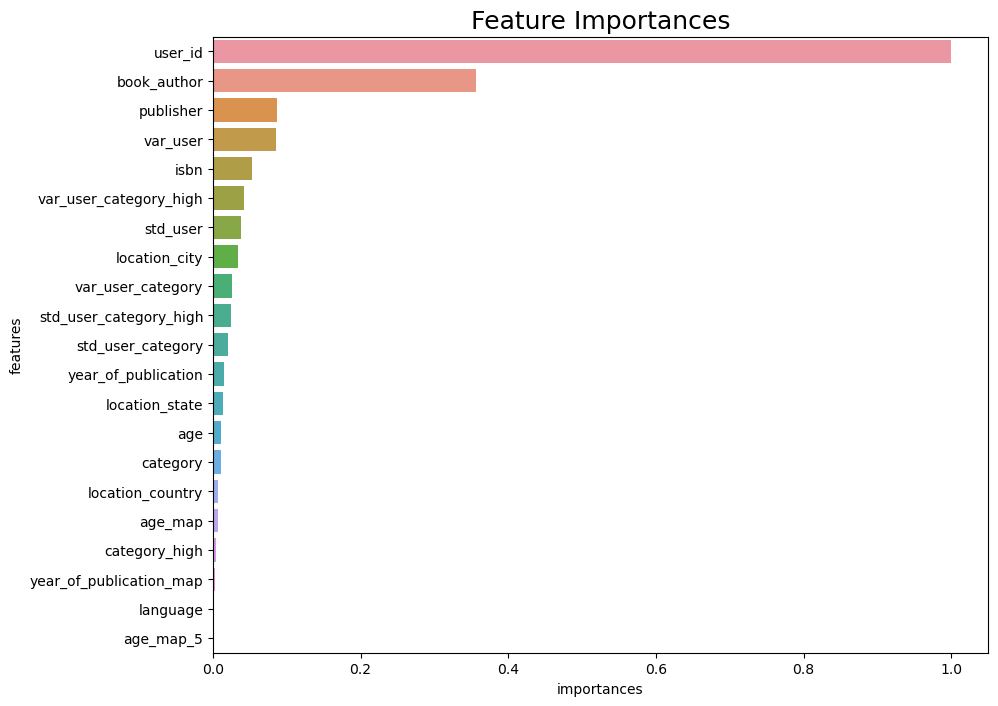

In [17]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importances', y='features', data=importances)
plt.title('Feature Importances', fontsize=18)
plt.show()